In [1]:
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.optim as optim

from torch.utils. data import DataLoader, TensorDataset 
from sklearn.datasets import make_classification 

sns.set()

In [2]:
colors = ['#fe7c73', '#2471A3']
plt.rcParams['font.family'] = ['Comic Sans MS', 'sans-serif']
torch.manual_seed(20)

In [3]:
ratio = {0:10, 1:90}

X, y = make_classification(
    n_samples=1000, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0,
    weights=[ratio[0] / 100, ratio[1] / 100], 
    class_sep=0.5, 
    random_state=6

)

unique, counts = np.unique(y, return_counts = True) 
class_distribution = dict(zip(unique, counts))
print("Class distribution: ", class_distribution)

Class distribution:  {0: 103, 1: 897}


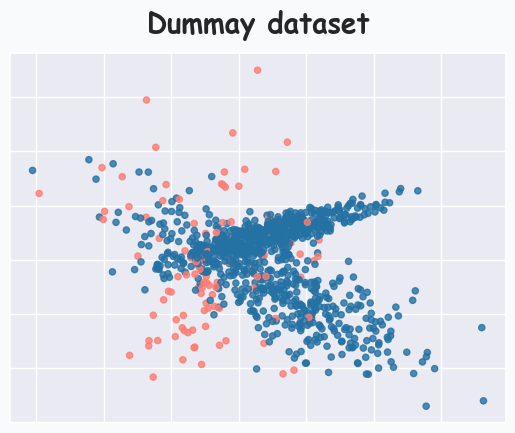

In [4]:
fig, ax = plt.subplots(facecolor="#f8fafc")
plt.scatter(X[:,0], X[:,1], c=[colors[int(i)] for i in y], s=20, alpha=0.8)
ax.set_title("Dummay dataset", fontsize=20, fontweight="bold", pad=15)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

In [5]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()

        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Linear(output_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

In [6]:
def compute_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

In [7]:
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y).view(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
input_size = 2 
hidden_size = 256 
output_size = 1 

model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Training loop
epochs = 100

for epoch in range(epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()  # Zero the gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the BCE loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
    accuracy = compute_accuracy(model, dataloader)
    
    if epoch%10==0:
        
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {round(loss.item(),2)}, Accuracy: {accuracy}')

Epoch 1/100, Loss: 0.84, Accuracy: 0.103
Epoch 11/100, Loss: 0.68, Accuracy: 0.897
Epoch 21/100, Loss: 0.63, Accuracy: 0.897
Epoch 31/100, Loss: 0.59, Accuracy: 0.897
Epoch 41/100, Loss: 0.38, Accuracy: 0.897
Epoch 51/100, Loss: 0.56, Accuracy: 0.897
Epoch 61/100, Loss: 0.42, Accuracy: 0.897
Epoch 71/100, Loss: 0.23, Accuracy: 0.897
Epoch 81/100, Loss: 0.21, Accuracy: 0.897
Epoch 91/100, Loss: 0.38, Accuracy: 0.897


In [10]:
x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,0].min() - 1, X[:,0].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

meshgrid_data = np.c_[xx.ravel(), yy.ravel()]

batch_size = 32 

num_batches = len(meshgrid_data) // batch_size 
remainder = len(meshgrid_data) % batch_size

In [11]:
predictions = []

model.eval() 
with torch.no_grad(): 
    for i in range(num_batches):
        start_idx = i * batch_size 
        end_idx = (i + 1) * batch_size 
        batch_tensor = torch.FloatTensor(meshgrid_data[start_idx:end_idx])
        batch_predictions = torch.sigmoid(model(batch_tensor)).numpy()
        predictions.extend(batch_predictions)

    if remainder > 0: 
        batch_tensor = torch.FloatTensor(meshgrid_data[-remainder:])
        batch_predictions = torch.sigmoid(model(batch_tensor)).numpy()
        predictions.extend(batch_predictions)

Text(0, 0.5, 'Feature 2')

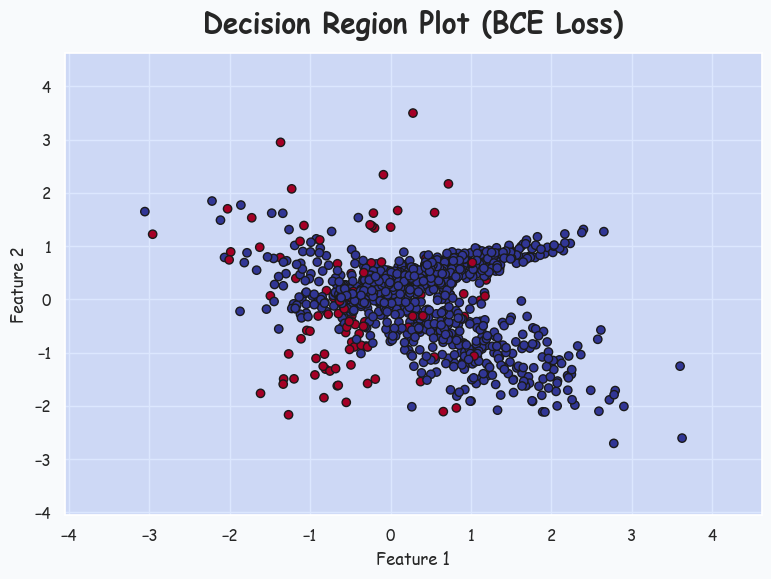

In [12]:
predictions = np.array(predictions).reshape(xx.shape)
predictions = np.where(predictions>=0.5, 1, 0)

plt.figure(figsize=(9, 6), facecolor="#f8fafc")
plt.contourf(xx, yy, predictions, cmap='coolwarm', alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='k', marker='o')
plt.title('Decision Region Plot (BCE Loss)', fontsize=20, fontweight='bold', pad=15)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=5, alpha=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma 
        self.alpha = alpha 
    
    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss 
        return torch.mean(focal_loss)


In [14]:
input_size = 2 
hidden_size = 256 
output_size = 1 

model = SimpleNN(input_size, hidden_size, output_size)
criterion = FocalLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [15]:
epochs = 100 

for epoch in range(epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad() 

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step() 

    accuracy = compute_accuracy(model, dataloader)

    if epoch%10==0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {round(loss.item(), 2)}, Accuracy: {accuracy}')

Epoch 1/100, Loss: 0.0, Accuracy: 0.897
Epoch 11/100, Loss: 0.0, Accuracy: 0.92
Epoch 21/100, Loss: 0.0, Accuracy: 0.928
Epoch 31/100, Loss: 0.0, Accuracy: 0.93
Epoch 41/100, Loss: 0.0, Accuracy: 0.928
Epoch 51/100, Loss: 0.0, Accuracy: 0.927
Epoch 61/100, Loss: 0.0, Accuracy: 0.931
Epoch 71/100, Loss: 0.0, Accuracy: 0.931
Epoch 81/100, Loss: 0.0, Accuracy: 0.932
Epoch 91/100, Loss: 0.0, Accuracy: 0.935


In [16]:
# Create a meshgrid for visualization
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Flatten the meshgrid and make predictions in mini-batches
meshgrid_data = np.c_[xx.ravel(), yy.ravel()]

# Define the batch size
batch_size = 32

# Split meshgrid_data into mini-batches
num_batches = len(meshgrid_data) // batch_size
remainder = len(meshgrid_data) % batch_size

In [17]:
# Make predictions in mini-batches
predictions = []

model.eval()
with torch.no_grad():
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        batch_tensor = torch.FloatTensor(meshgrid_data[start_idx:end_idx])
        batch_predictions = torch.sigmoid(model(batch_tensor)).numpy()
        predictions.extend(batch_predictions)

    # Process the remainder
    if remainder > 0:
        batch_tensor = torch.FloatTensor(meshgrid_data[-remainder:])
        batch_predictions = torch.sigmoid(model(batch_tensor)).numpy()
        predictions.extend(batch_predictions)

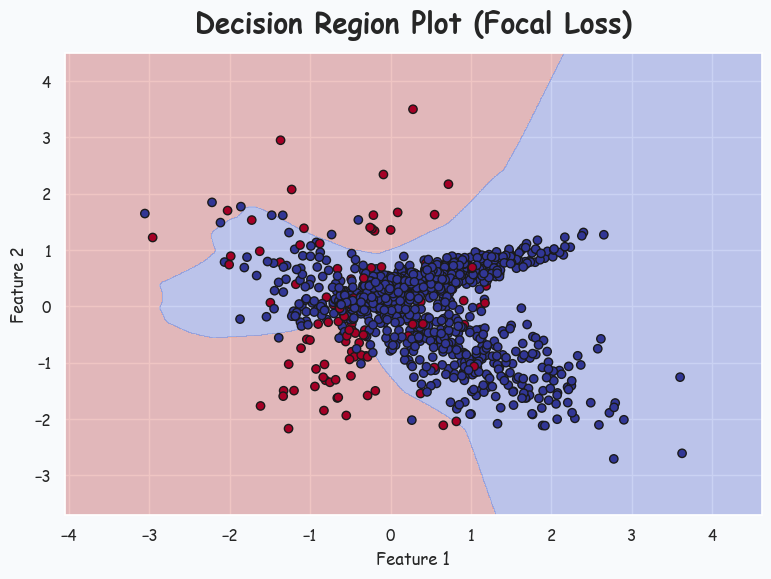

In [18]:
# Reshape predictions to match the meshgrid shape
predictions = np.array(predictions).reshape(xx.shape)
predictions = np.where(predictions>=0.5, 1, 0)

# Plot the decision boundary
plt.figure(figsize=(9, 6), facecolor="#f8fafc")
plt.contourf(xx, yy, predictions, cmap='coolwarm_r', alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='k', marker='o')
plt.title('Decision Region Plot (Focal Loss)', fontsize=20, fontweight="bold", pad=15)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
